In [1]:
import torch
from torch import nn, optim

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = [12,8]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

In [2]:
data = sns.load_dataset("flights")
data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


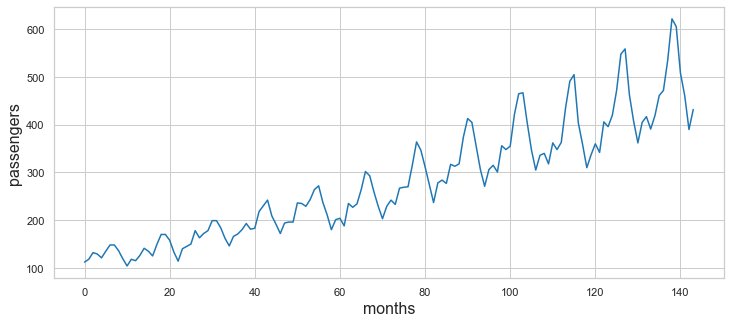

In [3]:
plt.figure(figsize=[12., 5.])
ax = sns.lineplot(data.index, data.passengers, data=data)
ax.set_xlabel('months');

In [4]:
data.passengers = data.passengers.astype(np.float32)

train_data = data.passengers[:-12].to_numpy()
test_data  = data.passengers[-12:].to_numpy()

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train_data = scaler.fit_transform(train_data.reshape(-1, 1))
scaled_train_data = torch.tensor(scaled_train_data, dtype=torch.float32)

In [5]:
def get_batches(data, window):

    sequences = []
    L = len(data)
    for i in range(L - window):
        sequence = data[i:i + window]
        label = data[i + window: i + window + 1]
        sequences.append((sequence, label))
        
    return sequences

seq_len  = 12
seq_data = get_batches(scaled_train_data, 12)

In [6]:
len(seq_data)

120

In [7]:
class flightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hs):
        
        # format input to shape (batch_size, seq_len, input_size) 
        x = x.view(1, len(x), 1) 
        
        out, hs = self.lstm(x, hs)
        
        # flatten LSTM input for fully connected layer: (batch_size, hidden_size)
        out = out.view(-1, self.hidden_size)
        
        out = self.fc(out)
        
        return out[-1], hs
        

In [8]:
input_size = 1
hidden_size = 3
num_layers = 1
output_size = 1

model = flightLSTM(input_size, hidden_size, num_layers, output_size)

In [9]:
def train(model, epochs, train_set, lr=0.001, print_every=10):
    
    criterion = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    
    for e in range(epochs):
        hidden = None
        for x, y in train_set:
            
            opt.zero_grad()
            
            out, hidden = model(x, hidden)
        
            loss = criterion(out, y.squeeze(0))
            loss.backward()
            opt.step()
            
            hidden = tuple([h.data for h in hidden])
            
        if e % print_every == 0:
            print(f'Epoch {e} Training Loss: {loss}')
            
    
            

In [10]:
train(model, 100, seq_data)

Epoch 0 Training Loss: 0.5123298764228821
Epoch 10 Training Loss: 0.035197801887989044
Epoch 20 Training Loss: 0.0009408455807715654
Epoch 30 Training Loss: 0.005591222085058689
Epoch 40 Training Loss: 0.021069012582302094
Epoch 50 Training Loss: 0.032136429101228714
Epoch 60 Training Loss: 0.03804697468876839
Epoch 70 Training Loss: 0.04110771790146828
Epoch 80 Training Loss: 0.04277241602540016
Epoch 90 Training Loss: 0.043768152594566345


In [22]:
# Get predictions on training data
predictions = []
for x, _ in seq_data:
    hidden = None
    out, hidden = model(x, hidden)
    out = scaler.inverse_transform(out.detach().numpy().reshape(-1, 1))
    predictions.append(out)
    

In [44]:
# Get predictions on validation data
init_data = torch.tensor(train_data[-12:]).unsqueeze(1)
# hidden = None
# out, hidden = model(init_data, hidden)
# out
for i in range(12):
    hidden = None
    out, hidden = model(init_data, hidden)
    np.append(init_data, out.detach().numpy())
    init_data = np.delete(init_data, 0)
    

In [45]:
\\

tensor([])

In [15]:
preds = np.array(predictions)

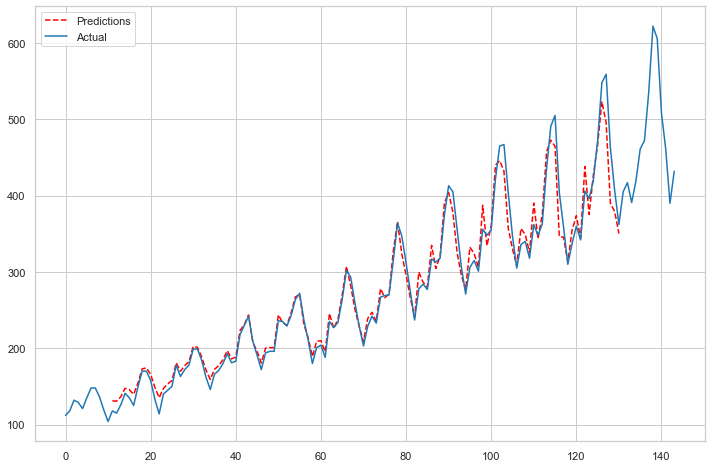

In [18]:
prediction_time = np.arange(11, len(data) - 13)
plt.plot(prediction_time, preds.squeeze(), 'r--', label='Predictions', )
plt.plot(data.passengers.to_numpy(), label='Actual')
plt.legend()

In [ ]:
test_data